In [1]:
from odes.models import SIR
from odes.integrator import integrator
from odes.neural_ODE import nUIV_NODE
import torch
# import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# helper function to step the SIR model forward and generate a data set
def generate_SIR_data(model, num_steps):
    t = torch.zeros(num_steps)
    y = torch.zeros(3, num_steps)
    y[:, 0] = torch.from_numpy(model.x)
    t[0] = torch.tensor(0.0)
    for i in range(num_steps):
        y[:, i] = torch.from_numpy(model.step())
        t[i] = torch.tensor(model.t)
    return y, t


def lp_norm_loss(y, yhat, p=2):
    return torch.norm(y-yhat, p=p)

In [3]:
# setting up SIR reference data
num_hosts = 50
num_steps = 400
dt = 0.05
torch.manual_seed(666)

time_scale = 25.0  # can make time "move faster" by scaling these constants beyond [0, 1]
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.75, 0.25, 0.0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

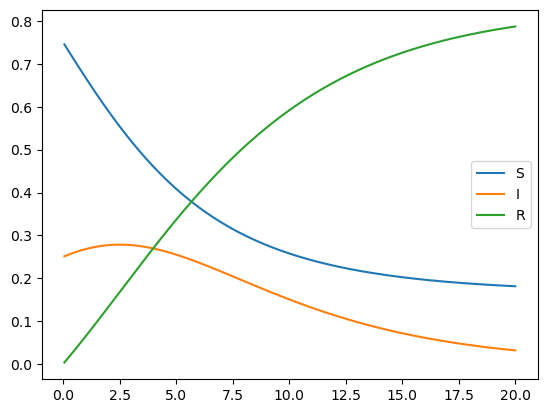

In [4]:
plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [5]:
num_epochs = 200

method = 'euler'
step_size = 2*dt
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nUIV_NODE(num_hosts, method=method, step_size=step_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

loss_function = lambda y, yhat: lp_norm_loss(y, yhat, p=2)  # nn.L1Loss()

y_train = torch.cat((SIR_train_data[0,:], SIR_train_data[1,:], SIR_train_data[2,:]))

In [6]:
print(model.nUIV_to_SIR.W.weight)

Parameter containing:
tensor([[ 0.0068,  0.4026, -0.5508],
        [ 0.4266, -0.0220,  0.2228],
        [-0.5294,  0.0567, -0.3501]], requires_grad=True)


In [7]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    y_est = torch.cat((SIR_est[0,:], SIR_est[1,:], SIR_est[2,:]))
    loss = loss_function(y_est, y_train.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')
    # break

g:\UCLA\Research\Epidemiology\epidemiology_sysID\odes\neural_ODE.py:66: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)
  rhs[2::3] += torch.matmul(state[2::3].T, torch.matmul(torch.diag(normalization), self.ts))


Epoch 0, loss value: 17.125553131103516.
Epoch 1, loss value: 14.100363731384277.
Epoch 2, loss value: 12.972660064697266.
Epoch 3, loss value: 11.923023223876953.
Epoch 4, loss value: 10.602840423583984.
Epoch 5, loss value: 9.139965057373047.
Epoch 6, loss value: 8.504460334777832.
Epoch 7, loss value: 8.485052108764648.
Epoch 8, loss value: 7.768677711486816.
Epoch 9, loss value: 7.505303382873535.
Epoch 10, loss value: 7.325275421142578.
Epoch 11, loss value: 6.962500095367432.
Epoch 12, loss value: 6.623704433441162.
Epoch 13, loss value: 6.427908420562744.
Epoch 14, loss value: 6.255405426025391.
Epoch 15, loss value: 6.063038349151611.
Epoch 16, loss value: 5.930809497833252.
Epoch 17, loss value: 5.838741779327393.
Epoch 18, loss value: 5.702097415924072.
Epoch 19, loss value: 5.495059967041016.
Epoch 20, loss value: 5.2302470207214355.
Epoch 21, loss value: 4.892377853393555.
Epoch 22, loss value: 4.480228900909424.
Epoch 23, loss value: 4.0234785079956055.
Epoch 24, loss valu

In [8]:
nUIV_params = model.get_params()
SIR_params = {'beta': beta,
              'gamma': gamma,
              'x0': SIR_x0,
              'num_hosts': num_hosts}

sim_params = {'SIR': SIR_params,
              'nUIV': nUIV_params}

print(nUIV_params)

{'beta': array([ 1.0200759 ,  2.40183   ,  0.12132348,  1.9029108 ,  2.4606538 ,
        1.4471828 ,  4.134869  ,  2.1449347 ,  1.8592454 ,  1.1544352 ,
       11.2365    ,  8.203539  ,  0.09125359,  1.3859595 ,  2.311501  ,
        1.805474  ,  6.324711  ,  1.0084895 ,  2.7212818 ,  1.4736183 ,
        3.4073265 ,  1.4124494 ,  5.561158  ,  0.92384034,  3.9085107 ,
       10.4061365 ,  9.028836  ,  2.8802283 ,  3.4960191 ,  2.2905426 ,
        2.4682057 ,  4.1779785 ,  8.199971  ,  4.7187395 ,  0.2953259 ,
        0.59773564,  2.1842625 , 16.900541  ,  3.7637773 ,  0.22389051,
        5.80411   , 10.8045225 ,  6.784635  ,  3.6934261 ,  6.4325137 ,
        0.2363659 ,  4.621505  ,  4.1041446 ,  1.1943815 ,  3.1591427 ],
      dtype=float32), 'delta': array([1.9697143e-02, 2.9692560e-09, 4.0669027e-01, 5.4359127e-15,
       1.2672865e-05, 7.7785778e-11, 1.3731004e-01, 4.6962996e+00,
       3.0921743e+00, 2.3608833e-09, 1.6128657e-02, 4.3831533e-01,
       6.2371653e-01, 9.1881928e-04, 1

Resetting to stored initial state.
Resetting to t=0.0.


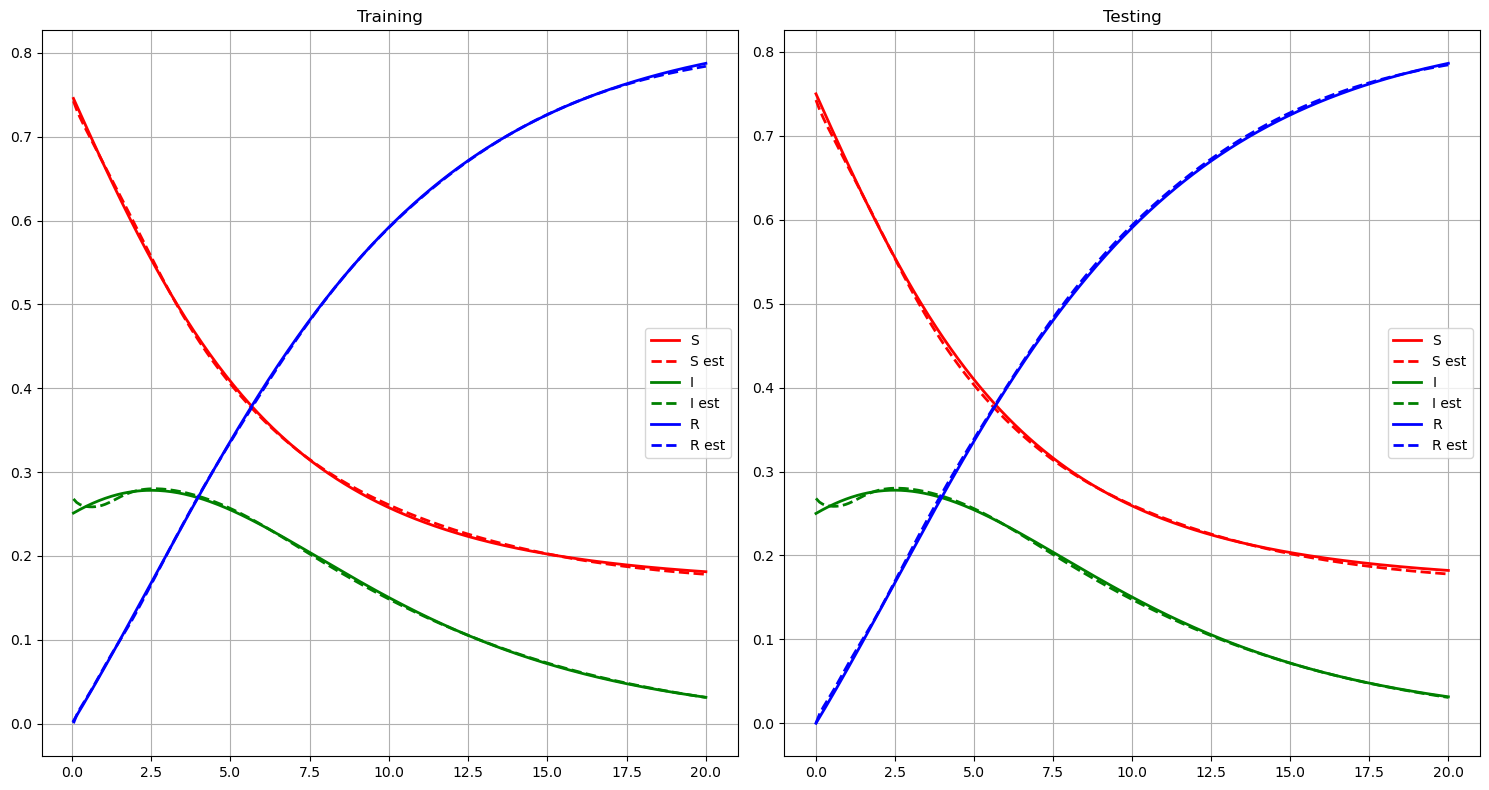

In [9]:
SIR_stepper.reset()
SIR_stepper.dt = 0.001
num_steps = 20000
SIR_test_data, time_test_data = generate_SIR_data(SIR_stepper, num_steps)

with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()
    SIR_test_data_est = model.simulate(time_test_data.to(device)).detach().cpu().numpy()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']

for i, name in enumerate(names):
    ax1.plot(time_train_data, SIR_train_data[i, :], lw=2, color=colors[i], label=name)
    ax1.plot(time_train_data, SIR_train_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
    ax2.plot(time_test_data, SIR_test_data[i, :], lw=2, color=colors[i], label=name)
    ax2.plot(time_test_data, SIR_test_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')


# ax1.plot(time_train_data[3:], SIR_train_data[1, 3:], lw=2, color=colors[1], label=names[1])
# ax1.plot(time_train_data[3:], SIR_train_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
# ax2.plot(time_test_data[3:], SIR_test_data[1, 3:], lw=2, color=colors[1], label=names[1])
# ax2.plot(time_test_data[3:], SIR_test_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax1.set_title('Training')
ax2.set_title('Testing')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
f.tight_layout()

path = './tmp/'
if not os.path.exists(path):
    os.mkdir(path)
filename = os.path.join(path, 'last_run_pytorch.png')
f.savefig(filename)
plt.show()

In [10]:
model.nUIV_to_SIR.W.weight

Parameter containing:
tensor([[ 1.2612,  0.4478, -0.2784],
        [ 0.5826, -0.4032,  1.1807],
        [-0.4509,  1.6215,  0.3785]], requires_grad=True)